In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


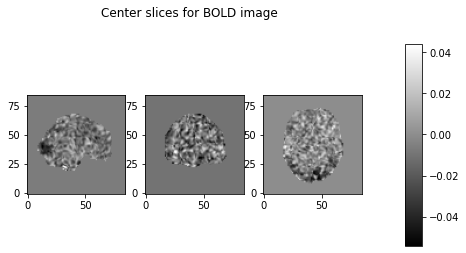

In [ ]:
# Load the BOLD image dataset
import nibabel as nib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

img = nib.load('/content/drive/My Drive/Trento/Data/500daysclip_fMRI.nii.gz')
mask = nib.load('/content/drive/My Drive/Trento/Data/mask.nii')
mask = mask.get_fdata()
mask = np.asarray(mask)
img = img.get_fdata()

def show_slices(slices, color):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       im = axes[i].imshow(slice.T, cmap=color, origin="lower")
       cbar_ax = fig.add_axes([1.0, 0.15, 0.04, 0.7])
       
       if i == 2:
         fig.colorbar(im, cax=cbar_ax)

slice_0 = img[42, :, :, 0]
slice_1 = img[:, 42, :, 0]
slice_2 = img[:, :, 42, 0]
show_slices([slice_0, slice_1, slice_2], color='gray')
plt.suptitle("Center slices for BOLD image");

In [ ]:
emb = pd.read_csv('/content/drive/My Drive/Trento/Data/embeddings.csv', index_col=0)
emb

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,Frame
0,-0.121128,-0.100518,-0.127005,-0.110293,-0.091745,0.134501,-0.030141,-0.108193,0.650376,0.156001,-0.153225,0.319476,0.192700,-0.060791,-0.065349,-0.079324,0.150185,0.057291,-0.064692,-0.108434,0.039025,-0.102758,0.129499,-0.133696,0.026979,-0.177388,-0.173443,-0.108176,0.717238,-0.002510,0.107578,0.319797,0.515953,0.154728,0.085742,-0.161282,0.398448,0.199583,0.018157,0.024475,...,-0.114724,0.015804,1.018350,-0.013969,-0.048941,-0.107328,-0.056437,0.577031,-0.063604,0.141023,-0.071919,0.034793,-0.041833,0.240607,0.491130,-0.044260,0.023812,0.123464,-0.124870,-0.085764,0.155510,-0.018569,-0.023418,0.865991,-0.129577,0.704285,-0.073532,0.294874,1.030028,-0.015058,-0.167739,0.140594,-0.099647,0.011544,0.050826,0.384126,0.078956,-0.137297,-0.012757,0
1,-0.120652,-0.101499,-0.126397,-0.110291,-0.090335,0.134451,-0.028300,-0.107337,0.655657,0.158575,-0.153568,0.321741,0.194135,-0.060823,-0.067826,-0.079977,0.150285,0.055217,-0.067527,-0.108586,0.039959,-0.103530,0.127703,-0.134190,0.027385,-0.177084,-0.173055,-0.108054,0.712156,-0.003535,0.105895,0.320177,0.513093,0.151901,0.085008,-0.162497,0.398293,0.197959,0.015187,0.026721,...,-0.115072,0.017170,1.022700,-0.012952,-0.048405,-0.107429,-0.058350,0.576872,-0.064267,0.140428,-0.071935,0.033815,-0.040214,0.241247,0.487457,-0.044289,0.026080,0.126504,-0.124723,-0.086021,0.156854,-0.020079,-0.025218,0.872271,-0.129734,0.705493,-0.073264,0.297240,1.027782,-0.012131,-0.168972,0.139195,-0.098751,0.013635,0.053593,0.379054,0.074829,-0.137290,-0.014737,30
2,-0.125237,-0.114113,-0.116405,-0.085077,-0.104330,0.123459,0.011412,-0.105174,0.552893,0.143013,-0.151535,0.374566,0.234827,-0.055642,-0.026038,-0.087900,0.079201,0.064523,-0.071952,-0.115311,0.078264,-0.095576,0.131819,-0.134139,0.012766,-0.170260,-0.181018,-0.112940,0.812944,0.022939,0.125170,0.262466,0.431399,0.167266,0.106283,-0.143823,0.354919,0.256761,0.003037,-0.009829,...,-0.122245,0.010450,1.049774,0.012118,-0.071261,-0.117299,-0.040613,0.653714,-0.035768,0.184057,-0.045104,0.022734,-0.051198,0.273329,0.463202,-0.077221,0.016115,0.125962,-0.125274,-0.088850,0.111925,-0.013405,-0.054514,0.812400,-0.121116,0.767526,-0.067284,0.376410,1.105997,-0.050712,-0.176627,0.119065,-0.065892,0.000208,0.088327,0.392520,0.033023,-0.128169,-0.011925,60
3,-0.125184,-0.120691,-0.116990,-0.086772,-0.098762,0.122810,0.014805,-0.106088,0.557028,0.137906,-0.151617,0.370109,0.232280,-0.057123,-0.030707,-0.088190,0.080986,0.058176,-0.071005,-0.115856,0.084330,-0.095775,0.129363,-0.131587,0.012312,-0.169665,-0.180224,-0.112950,0.801040,0.019664,0.123975,0.260078,0.431473,0.172002,0.107815,-0.143701,0.363134,0.254212,0.001748,-0.009956,...,-0.119809,0.006178,1.046954,0.012224,-0.073850,-0.117447,-0.041892,0.653367,-0.037213,0.181551,-0.042609,0.023184,-0.047566,0.261959,0.472677,-0.076893,0.011144,0.123700,-0.125106,-0.090938,0.106342,-0.012396,-0.050284,0.808641,-0.121429,0.760001,-0.067393,0.377659,1.108203,-0.052171,-0.177388,0.117352,-0.064266,0.001389,0.096250,0.380604,0.031835,-0.128036,-0.016034,90
4,-0.128576,-0.062711,-0.119620,-0.106651,-0.083859,0.128329,0.006780,-0.087923,0.387625,0.160412,-0.155791,0.316185,0.337854,-0.056065,-0.080658,-0.098568,0.049930,-0.027400,-0.101303,-0.111940,0.155753,-0.093978,0.175489,-0.185920,-0.034592,-0.165920,-0.187051,-0.107288,0.766950,0.082650,0.124118,0.407784,0.384418,0.163697,-0.034631,-0.160348,0.165400,0.319093,0.078029,0.020393,...,-0.111880,-0.022621,1.219407,0.005743,-0.025993,-0.117523,-0.036432,0.632345,-0.025268,0.298652,-0.008799,0.083927,-0.024279,0.358242,0.484618,-0.070286,-0.028955,0.133598,-0.124080,-0.096800,0.134293,-0.065277,-0.080060,0.881459,-0.116887,0.903682,-0.076165,0.4

     |████████████████████████████████| 17.3MB 230kB/s 
ERROR: xarray 0.18.0 has requirement numpy>=1.17, but you'll have numpy 1.16.4 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.16.4 which is incompatible.
ERROR: pyarrow 3.0.0 has requirement numpy>=1.16.6, but you'll have numpy 1.16.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: astropy 4.2.1 has requirement numpy>=1.17, but you'll have numpy 1.16.4 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


     |████████████████████████████████| 2.3MB 7.0MB/s 


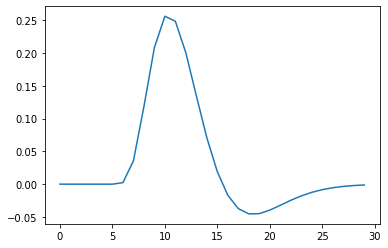

In [ ]:
# Convolve with hemodynamic response function (HRF)

!pip install numpy==1.16.4
!pip install nipy

import nipy.modalities.fmri.hemodynamic_models as hm
import matplotlib.pyplot as plt

# fMRI repetition time (RT)
RT=1

# Plot an example
plt.plot(hm.glover_hrf(RT, oversampling=1., time_length=30*RT, onset=4*RT))

In [ ]:
from sklearn import preprocessing

embhrf = np.zeros((1280, 721))

# Normalize embeddings first and then convolve
x = emb.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
emb = pd.DataFrame(x_scaled)

for i in range(0,1280):
  embhrf[i] = np.convolve(emb.iloc[:,i], hm.glover_hrf(RT, oversampling=1., time_length=100*RT, onset=4*RT))

embhrf = pd.DataFrame(embhrf)

# x = embhrf.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# embhrf = pd.DataFrame(x_scaled)

embhrf = np.transpose(embhrf)[:600]
embhrf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
import math
from sklearn.model_selection import train_test_split # data split
from sklearn.linear_model import Ridge # Regression algorithm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error # evaluation metric

dim1 = img.shape[0]
dim2 = img.shape[1]
dim3 = img.shape[2]

R2 = np.zeros([dim1, dim2, dim3])
MAE = np.zeros([dim1, dim2, dim3])
RMSE = np.zeros([dim1, dim2, dim3])


for i in range(0, dim1):
  for j in range(0, dim2):
    for k in range(0, dim3):
      if mask[i,j,k] != 0:

        y = img[i,j,k,:]
        # Random shuffle train and test sets
        X_train, X_test, y_train, y_test = train_test_split(embhrf, y, random_state = 5000, test_size = 0.5)
        ridge = Ridge(alpha = 0.1)
        ridge.fit(X_train, y_train)
        ridge_yhat = ridge.predict(X_test)

        R2[i, j, k] = r2_score(y_test, ridge_yhat)
        MAE[i, j, k] =  mean_absolute_error(y_test, ridge_yhat)
        RMSE[i, j, k] =  math.sqrt(mean_squared_error(y_test, ridge_yhat))


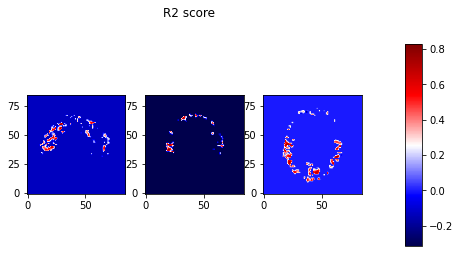

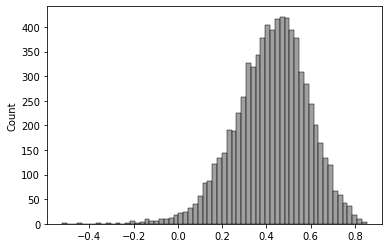

In [ ]:
import seaborn as sns

slice_0 = R2[42, :, :]
slice_1 = R2[:, 42, :]
slice_2 = R2[:, :, 42]
show_slices([slice_0, slice_1, slice_2], color='seismic')
plt.suptitle("R2 score")  
plt.figure()
sns.histplot(data = R2[R2 != 0].flatten(), color = 'grey');

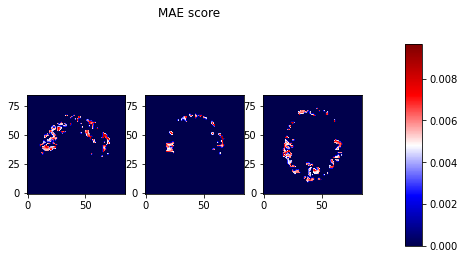

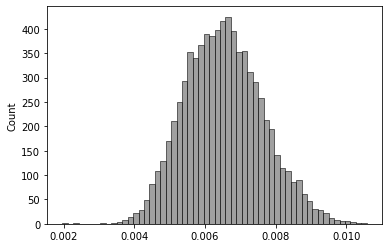

In [ ]:
slice_0 = MAE[42, :, :]
slice_1 = MAE[:, 42, :]
slice_2 = MAE[:, :, 42]
show_slices([slice_0, slice_1, slice_2], color='seismic')
plt.suptitle("MAE score")
plt.figure()
sns.histplot(data = MAE[MAE!= 0].flatten(), color = 'grey');

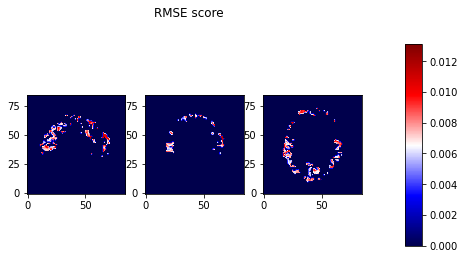

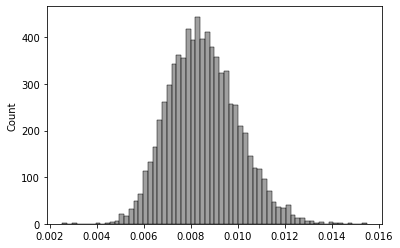

In [ ]:
slice_0 = RMSE[42, :, :]
slice_1 = RMSE[:, 42, :]
slice_2 = RMSE[:, :, 42]
show_slices([slice_0, slice_1, slice_2], color='seismic')
plt.suptitle("RMSE score")
plt.figure()
sns.histplot(data = RMSE[RMSE != 0].flatten(), color = 'grey');